In [1]:
import chandra
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.table import Table
import numpy as np
from astropy.coordinates import SkyCoord,Angle
import astropy.coordinates as coord
import astropy.units as u
import astropy

import glob
import pickle

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('notebook')

In [2]:
# USE THIS TO VERSION CONTROL YOUR SAVED CATALOGS

version = 'jun25_v1'

## Load Target Tables

In [3]:
hvs = Table.read('../data/hvs_targets.fits')
hvs['selection'] = 'hvs'

## Load and Select RV Standard

In [4]:
# Load RVS standards
rvs = Table.read('/home/ana/data/rvs_standards.fits')

In [5]:
# convert to sexagesimal coordinates
rra = coord.Angle(rvs['_RAJ2000'])
rvs['RAstring'] = rra.to_string(unit=u.hour, sep=':')

rdec = coord.Angle(rvs['_DEJ2000'])
rvs['DEstring'] = rdec.to_string(unit=u.deg, sep=':')

In [6]:
rvs

<Table length=1420>
  _RAJ2000     _DEJ2000    HIP   ...    _DE          RAstring        DEstring  
    deg          deg             ...    deg                                    
  float64      float64    int32  ...  float64         str17           str13    
------------ ------------ ------ ... ---------- ----------------- -------------
  0.92285278 -28.39619556    296 ... -28.396196  0:03:41.48466667 -28:23:46.304
  1.24465028 -70.21244500    407 ... -70.212445  0:04:58.71606667 -70:12:44.802
  1.28123000 -52.15174111    420 ... -52.151741      0:05:07.4952 -52:09:06.268
  1.39554222  53.17169361    466 ...  53.171694  0:05:34.93013333  53:10:18.097
  1.69571667  -4.35002639    556 ...  -4.350026       0:06:46.972  -4:21:00.095
  1.88558750 -23.81871944    616 ... -23.818719       0:07:32.541  -23:49:07.39
  1.90595917 -45.11953806    624 ... -45.119538      0:07:37.4302 -45:07:10.337
  2.17057583  36.62712500    699 ...  36.627125      0:08:40.9382   36:37:37.65
  2.24866167 -39.73715917    726 ... -39.737159      0:08:59.6788 -39:44:13.773
         ...          ...    ... ...        ...               ...           ...
357.95283806 -33.45249194 117668 ... -33.452492 23:51:48.68113333 -33:27:08.971
358.47597444  17.99176222 117836 ...  17.991762 23:53:54.23386667  17:59:30.344
358.65278139 -60.34934833 117878 ... -60.349348 23:54:36.66753333 -60:20:57.654
358.66092278 -40.30006250 117880 ... -40.300062 23:54:38.62146667 -40:18:00.225
358.88508139   3.50144694 117953 ...   3.501447 23:55:32.41953333   3:30:05.209
358.90631361 -51.37426000 117961 ... -51.374260 23:55:37.51526667 -51:22:27.336
359.38965528  -9.64751917 118115 ...  -9.647519 23:57:33.51726667  -9:38:51.069
359.45891611 -30.44794139 118143 ... -30.447941 23:57:50.13986667 -30:26:52.589
359.97430361 -22.42811333 118319 ... -22.428113 23:59:53.83286667 -22:25:41.208

### K giant selection

In [7]:
ind_giant = np.array([True if ('K' in sptype) else False for sptype in rvs['SpType']]) # too few giants!
ind_bhb = np.array([True if ('A' in sptype) else False for sptype in rvs['SpType']])
ind_msto = np.array([True if ('G' in sptype) else False for sptype in rvs['SpType']])
ind_f = np.array([True if ('F' in sptype) else False for sptype in rvs['SpType']])

print(np.sum(ind_giant), np.sum(ind_bhb), np.sum(ind_msto), np.sum(ind_f))

318 0 868 239


In [8]:
sel_rvs = (
    (rvs['Vmag'] < 8) &
    (rvs['Vmag'] > 5) &
    (ind_f) # PICK YOUR DESIRED SPECTRAL TYPE
)

print(np.sum(sel_rvs))

rvs = rvs[sel_rvs]
ind_f = np.array([True if (('F' in sptype)) else False for sptype in rvs['SpType']])
ind_giant = np.array([True if (('K' in sptype)) else False for sptype in rvs['SpType']])
ind_msto = np.array([True if (('G' in sptype) and ('IV' in sptype)) else False for sptype in rvs['SpType']])

rvs['ra'] = np.zeros(len(rvs))
rvs['dec'] = np.zeros(len(rvs))
rvs['name'] = ' '*16

for star in rvs:
    coor = coord.SkyCoord(ra=star['_RAJ2000']*u.deg, dec=star['_DEJ2000']*u.deg)
    
    star['ra'] = coor.ra.value
    star['dec'] = coor.dec.value
    star['name'] = 'HIP'+str(star['HIP'])

rvs['selection'] = 'rvs'
rvs['phot_g_mean_mag'] = rvs['Vmag']

160


In [9]:
# PICK YOUR RA AND DEC RANGE BELOW
# THE FIRST RANGE IS FOR EVENING TWILIGHT
# THE SECOND RANGE IS FOR MORNING TWILIGHT


# EVENING
rv_sel = (
    ((rvs['ra'] > 170) & (rvs['ra']<230))&
    (rvs['dec'] < -20)&
    (rvs['dec'] > -50)
)
print(np.sum(rv_sel & ind_f), np.sum(rv_sel & ind_msto))
rvstandard1 = rvs[rv_sel & ind_f][:] # select first star that satisfies criteria
rvstandard2 = rvs[rv_sel & ind_msto][:] # select first star that satisfies criteria

# MORNING
rv_sel = (

    ((rvs['ra'] > 330) & (rvs['ra'] < 360))&
    (rvs['dec'] < -10)&
    (rvs['dec'] > -60)

)
print(np.sum(rv_sel & ind_f), np.sum(rv_sel & ind_msto))
rvstandard3 = rvs[rv_sel & ind_f][:2] # select first star that satisfies criteria
rvstandard4 = rvs[rv_sel & ind_msto][:] # select first star that satisfies criteria

3 0
3 0


In [10]:
rvstandard = astropy.table.vstack((rvstandard1,))

In [11]:
rvstandard

<Table length=3>
  _RAJ2000     _DEJ2000    HIP   ...   name   selection phot_g_mean_mag
    deg          deg             ...                          mag      
  float64      float64    int32  ...  str16      str3       float32    
------------ ------------ ------ ... -------- --------- ---------------
212.35403750 -34.88290750  69157 ... HIP69157       rvs            7.77
221.93078333 -27.69906333  72353 ... HIP72353       rvs            7.55
222.65804056 -32.46652944  72600 ... HIP72600       rvs            7.46

### Match to Gaia DR3

#### Get source IDs first from the pre-matched Hipparcos table

In [12]:
ids = '(' + ' '.join(list('{:d},'.format(x) for x in rvstandard['HIP']))[:-1] + ')'
q_base ='''SELECT * FROM gaiadr3.hipparcos2_best_neighbour WHERE original_ext_source_id IN {:s}'''.format(ids)
print(q_base)

SELECT * FROM gaiadr3.hipparcos2_best_neighbour WHERE original_ext_source_id IN (69157, 72353, 72600)


In [13]:
job = Gaia.launch_job(q_base)

In [14]:
qmatch = job.get_results()
# qmatch.rename_column('SOURCE_ID', 'source_id')

In [15]:
qmatch

<Table length=3>
     source_id      original_ext_source_id ... number_of_neighbours xm_flag
                                           ...                             
       int64                int32          ...        int16          int16 
------------------- ---------------------- ... -------------------- -------
6121483060105219712                  69157 ...                    1      72
6219454940618807168                  72353 ...                    1       8
6205244027709918976                  72600 ...                    1       8

In [16]:
rvstandard = rvstandard[np.argsort(rvstandard['HIP'])]

In [17]:
rvstandard

<Table length=3>
  _RAJ2000     _DEJ2000    HIP   ...   name   selection phot_g_mean_mag
    deg          deg             ...                          mag      
  float64      float64    int32  ...  str16      str3       float32    
------------ ------------ ------ ... -------- --------- ---------------
212.35403750 -34.88290750  69157 ... HIP69157       rvs            7.77
221.93078333 -27.69906333  72353 ... HIP72353       rvs            7.55
222.65804056 -32.46652944  72600 ... HIP72600       rvs            7.46

In [18]:
qmatch = qmatch[np.argsort(qmatch['original_ext_source_id'])]

In [19]:
qmatch

<Table length=3>
     source_id      original_ext_source_id ... number_of_neighbours xm_flag
                                           ...                             
       int64                int32          ...        int16          int16 
------------------- ---------------------- ... -------------------- -------
6121483060105219712                  69157 ...                    1      72
6219454940618807168                  72353 ...                    1       8
6205244027709918976                  72600 ...                    1       8

In [20]:
rvstandard['source_id'] = qmatch['source_id']

#### Get proper motions

In [21]:
ids = '(' + ' '.join(list('{:d},'.format(x) for x in rvstandard['source_id']))[:-1] + ')'
q_base ='''SELECT * FROM gaiadr3.gaia_source WHERE source_id IN {:s}'''.format(ids)
print(q_base)

SELECT * FROM gaiadr3.gaia_source WHERE source_id IN (6121483060105219712, 6219454940618807168, 6205244027709918976)


In [22]:
job = Gaia.launch_job(q_base)

In [23]:
qrvs = job.get_results()
# qrvs.rename_column('SOURCE_ID', 'source_id')

In [24]:
rvstandard = rvstandard[np.argsort(rvstandard['source_id'])]

In [25]:
rvstandard

<Table length=3>
  _RAJ2000     _DEJ2000    HIP   ... phot_g_mean_mag      source_id     
    deg          deg             ...       mag                          
  float64      float64    int32  ...     float32            int64       
------------ ------------ ------ ... --------------- -------------------
212.35403750 -34.88290750  69157 ...            7.77 6121483060105219712
222.65804056 -32.46652944  72600 ...            7.46 6205244027709918976
221.93078333 -27.69906333  72353 ...            7.55 6219454940618807168

In [26]:
qrvs = qrvs[np.argsort(qrvs['source_id'])]

In [27]:
qrvs

<Table length=3>
    solution_id             designation          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 6121483060105219712 ...           MARCS
1636148068921376768 Gaia DR3 6205244027709918976 ...           MARCS
1636148068921376768 Gaia DR3 6219454940618807168 ...           MARCS

In [28]:
rvstandard['pmra'] = qrvs['pmra']
rvstandard['pmdec'] = qrvs['pmdec']

In [29]:
rvstandard

<Table length=3>
  _RAJ2000     _DEJ2000    HIP   ...         pmra               pmdec       
    deg          deg             ...       mas / yr            mas / yr     
  float64      float64    int32  ...       float64             float64      
------------ ------------ ------ ... ------------------- -------------------
212.35403750 -34.88290750  69157 ...  -58.56526595828141  -49.20286500845387
222.65804056 -32.46652944  72600 ... -109.11792133954512 -152.88418599115357
221.93078333 -27.69906333  72353 ...  -48.51726976211512  -33.00473533432895

### Plot airmasses for RV standards

In [30]:
from astroplan import Observer
from astropy.time import Time
from astroplan import FixedTarget
from astroplan.plots import plot_airmass, plot_altitude

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
lco = Observer.at_site('LCO')

In [33]:
time = Time("2025-06-26 5:00:00")

In [34]:
amtarg = [];

for row in rvstandard:
    coordi = SkyCoord(ra = row['_RAJ2000']*u.deg, dec = row['_DEJ2000']*u.deg)
    amtarg.append(FixedTarget(name = row['HIP'], coord = coordi))
    print(coordi.to_string('hmsdms', sep=':', precision=0))

14:09:25 -34:52:58
14:50:38 -32:28:00
14:47:43 -27:41:57


In [35]:
amtarg

[<FixedTarget "69157" at SkyCoord (ICRS): (ra, dec) in deg (212.3540375, -34.8829075)>,
 <FixedTarget "72600" at SkyCoord (ICRS): (ra, dec) in deg (222.65804056, -32.46652944)>,
 <FixedTarget "72353" at SkyCoord (ICRS): (ra, dec) in deg (221.93078333, -27.69906333)>]

<Axes: xlabel='Time from 2025-06-25 [UTC]', ylabel='Altitude'>

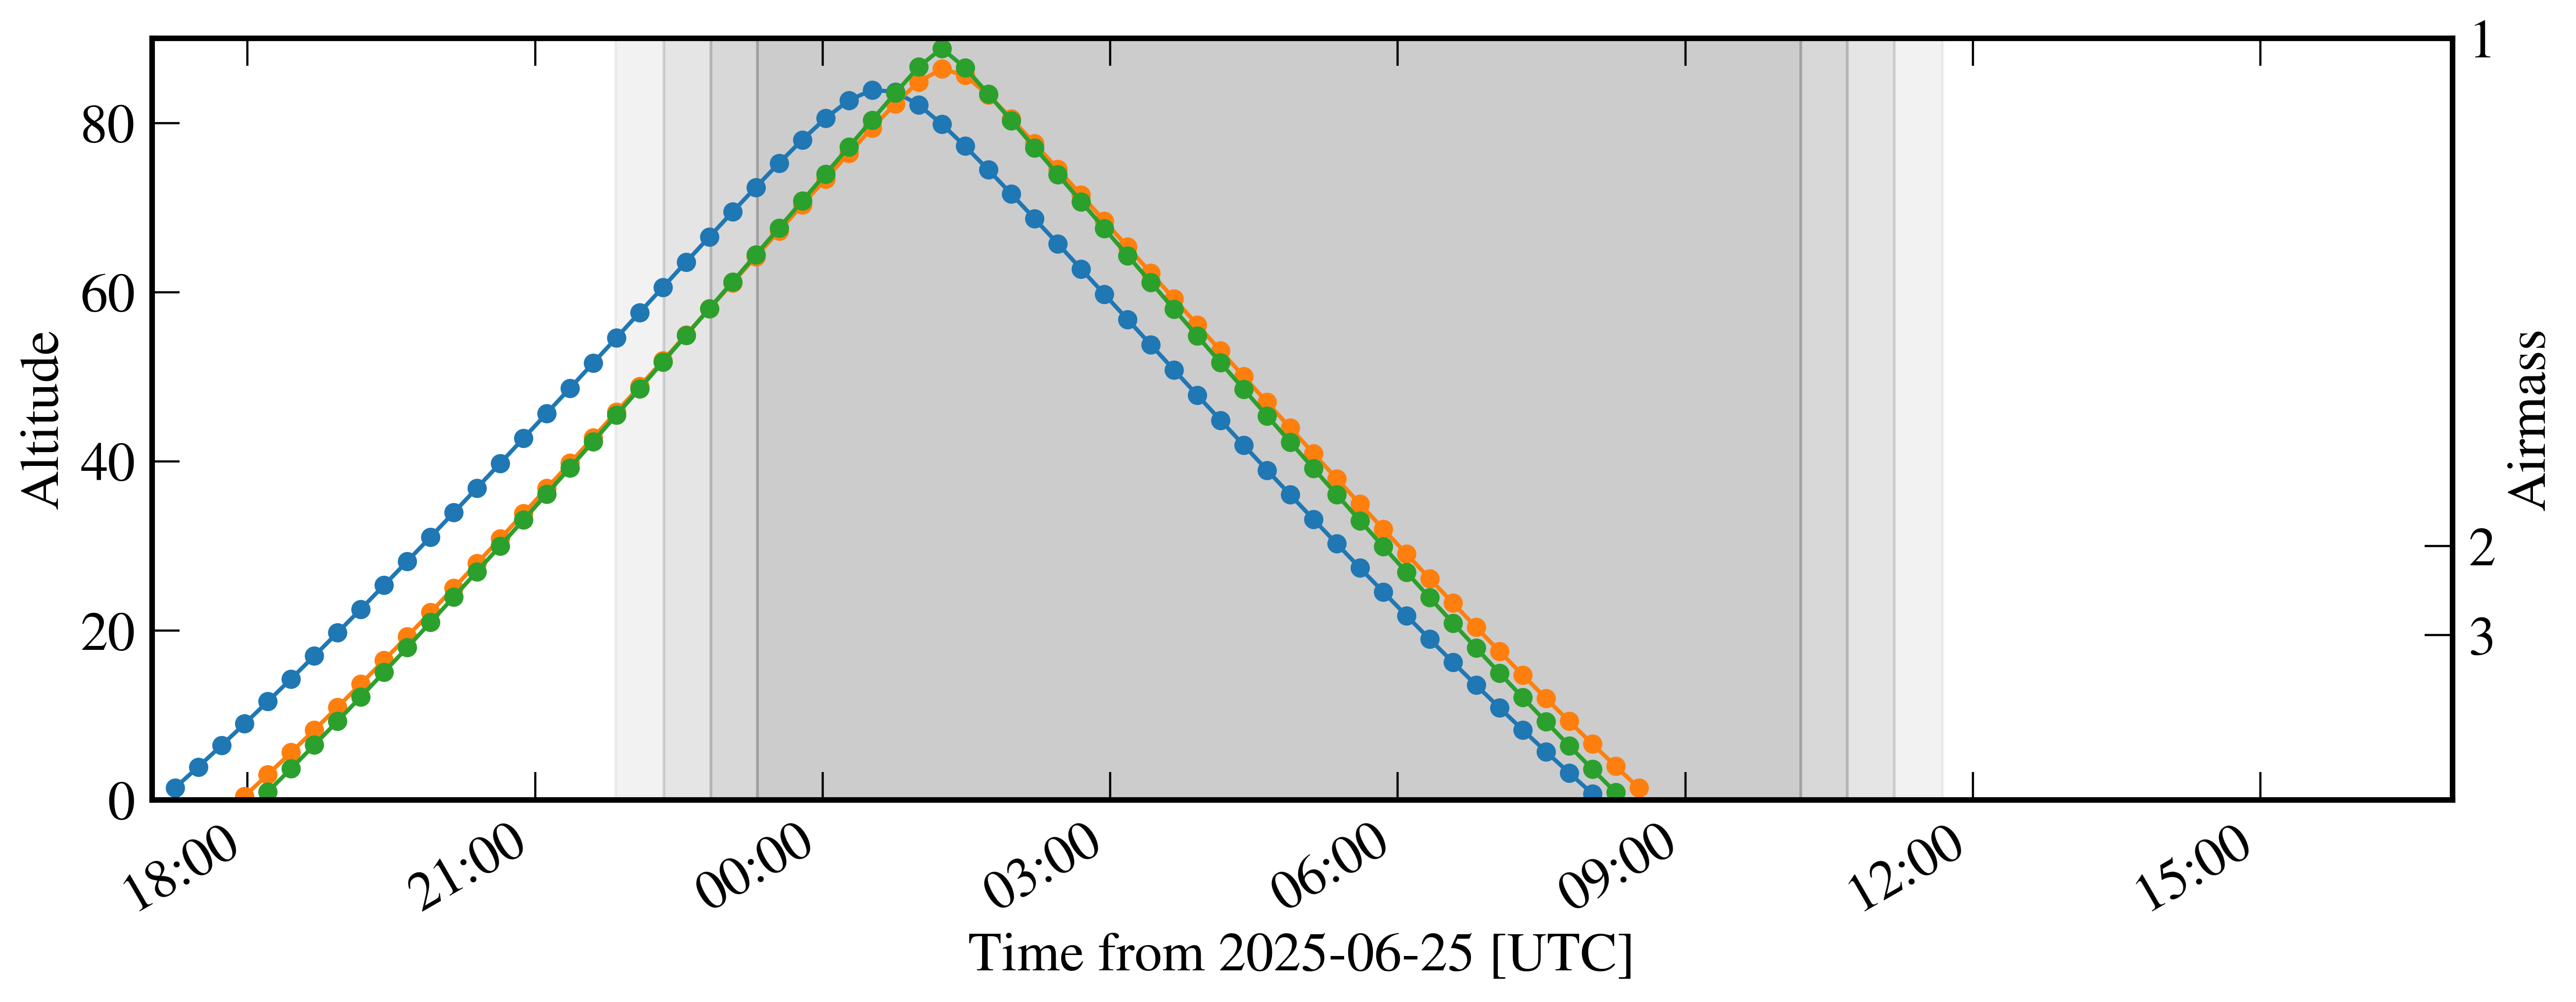

In [36]:
plt.figure(figsize = (15, 5))
plot_altitude(amtarg, observer=lco, time=time, brightness_shading=True,
             airmass_yaxis=True)

## Load Telluric Standard

In [37]:
from astropy.io import ascii

In [38]:
# SEARCH GEMINI FOR A NEARBY TELLURIC TO THE RV STANDARDS
# https://www.gemini.edu/observing/resources/near-ir-resources/spectroscopy/telluric-standard-search
# MANUALLY ADD THEIR DETAILS BELOW BY QUERYING THEM IN SIMBAD

telluric = ascii.read('''HIP70097  14:20:37.35  -34:40:40.4   7.70  A0V 6119802009905857792 215.15548433618 -34.67792755628 
HIP70993  14:31:13.08  -34:40:52.0   7.77  A0V 6119249299162268544 217.80447641310 -34.68119047806
HIP69104  14:08:44.35  -42:35:55.2   8.72  A0V 6109754535215827200 212.18468708482 -42.59869926164
''')

In [39]:
old_names = telluric.colnames
new_names = ['name', 'RAstring', 'DEstring', 'phot_g_mean_mag', 'SpType', 'source_id', 'ra', 'dec']
for old, new in zip(old_names, new_names):
    telluric.rename_column(old, new)

telluric['selection'] = 'tell'

In [40]:
telluric = telluric[np.argsort(telluric['source_id'])]

In [41]:
telluric

<Table length=3>
  name     RAstring    DEstring  ...        ra             dec       selection
  str8      str11       str11    ...     float64         float64        str4  
-------- ----------- ----------- ... --------------- --------------- ---------
HIP69104 14:08:44.35 -42:35:55.2 ... 212.18468708482 -42.59869926164      tell
HIP70993 14:31:13.08 -34:40:52.0 ...  217.8044764131 -34.68119047806      tell
HIP70097 14:20:37.35 -34:40:40.4 ... 215.15548433618 -34.67792755628      tell

### Match to Gaia DR3

In [42]:
ids = '(' + ' '.join(list('{:d},'.format(x) for x in telluric['source_id']))[:-1] + ')'
q_base ='''SELECT * FROM gaiadr3.gaia_source WHERE source_id IN {:s}'''.format(ids)
print(q_base)

SELECT * FROM gaiadr3.gaia_source WHERE source_id IN (6109754535215827200, 6119249299162268544, 6119802009905857792)


In [43]:
job = Gaia.launch_job(q_base)

In [44]:
qtell = job.get_results()
# qtell.rename_column('SOURCE_ID', 'source_id')

In [45]:
qtell = qtell[np.argsort(qtell['source_id'])]

In [46]:
qtell

<Table length=3>
    solution_id             designation          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 6109754535215827200 ...                
1636148068921376768 Gaia DR3 6119249299162268544 ...               A
1636148068921376768 Gaia DR3 6119802009905857792 ...               A

In [47]:
telluric['pmra'] = qtell['pmra']
telluric['pmdec'] = qtell['pmdec']

In [48]:
telluric

<Table length=3>
  name     RAstring    DEstring  ...         pmra               pmdec       
                                 ...       mas / yr            mas / yr     
  str8      str11       str11    ...       float64             float64      
-------- ----------- ----------- ... ------------------- -------------------
HIP69104 14:08:44.35 -42:35:55.2 ... -15.879933284222458  -5.747598434876086
HIP70993 14:31:13.08 -34:40:52.0 ...   -9.71328580156631 -14.412307911046593
HIP70097 14:20:37.35 -34:40:40.4 ... -27.250755942128976   -7.35124013170277

## Merge Target Catalogs

In [49]:
# all target tables should have these columns

selcol = ['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'selection', 'pmra', 'pmdec', 'ruwe',
         'pmra_error', 'pmdec_error']

In [50]:
rastart = 100 # change this to 'wrap' the RAs when sorting. (i.e. to put 24:00:00 before 00:00:00 etc.)

def ra_sort(tab):
    lowra = tab['ra'] < rastart
    ranew = np.array(tab['ra'])
    ranew[lowra] += 360
    return tab[np.argsort(ranew)]


# modify below to sort each input catalog by RA
hvs = ra_sort(hvs)

In [51]:
# Merge catalogs into master target table
targets = astropy.table.vstack([telluric, rvstandard, hvs])

In [52]:
len(targets)

139

### Remove duplicate targets that appear in multiple selections

In [53]:
un, c = np.unique(targets['source_id'], return_counts=True)
dup = un[c > 1]
dup = np.array(np.unique(targets[np.isin(targets['source_id'],dup)]['source_id']))

In [54]:
unique_ids = [];

mask = np.zeros(len(targets)).astype(bool)

for idx, row in enumerate(targets):
    if row['source_id'] in dup and row['source_id'] not in unique_ids:
        unique_ids.append(row['source_id'])
        mask[idx] = True
    elif row['source_id'] in dup and row['source_id'] in unique_ids:
        pass
    else:
        unique_ids.append(row['source_id'])
        mask[idx] = True

In [55]:
targets = targets[mask]

In [56]:
len(targets)

139

In [57]:
# # check if previously observed by other spectroscopic surveys
# # this can be removed and ignored


# tspec = Table.read('/Users/vedantchandra/0_research/data/gaia_giants/xpfeh/parent_giants_xpfeh_clean_xrv.h5')

# in_xrv = np.isin(tspec['source_id'], targets['source_id'])

# tspec[in_xrv]['distance_xp', 'survey', 'phot_g_mean_mag'] # not removing it, overlap is good

# in_xrv = np.isin(targets['source_id'], tspec['source_id'])

# targets[in_xrv]['selection'] # not removing it, overlap is good

In [58]:
# make names
targets['shortname'] = ' '*32
targets['title'] = ' '*32

for ii,target in enumerate(targets):
    
    coordi = SkyCoord(ra = target['ra'], dec = target['dec'], unit = 'deg')

    rastr = coordi.to_string('hmsdms').split()[0].replace('h', '').replace('m', '')[0:4]
    destr = coordi.to_string('hmsdms').split()[1].replace('d', '').replace('m', '')[0:5]

#name = '%s ' % target['selection'] + 'J' + rastr + destr
    if not isinstance (target['name'], str):
        name = 'J' + rastr + destr
    else:
        name = target['name']
    
    mag = np.round(target['phot_g_mean_mag'], 5)
    
    title = name + ' [G=%.1f]' % mag    
    shortname = name.replace(' ', '_').lower().replace('-', 'm').replace('+', 'p')
    
    target['shortname'] = shortname
    target['title'] = title

In [59]:
badstar = [
'j1000m2348',
'j1209m4627',
'j1226m4049',
'j1231m3711',
'j1403m4352',
'j1405m4255',
] # exclude stars with very close companions, or very faint (as seen in finder charts)

#### Previous run

In [60]:
# rcat = Table.read('/home/ana/data/mage_bonaca_rcat_V0.05.fits')

In [61]:
# rcat

In [62]:
observed = [] # exclude stars already observed
# ind_ngc7089 = rcat['tdb_selection']=='ngc7089'
# ind_ngc288 = rcat['tdb_selection']=='ngc288'

# mage_obs = ['j1416p0940',
# 'j1420p0909',
# 'j1438p0923',
# 'j1445p0619',
# 'j1459p0514',
# 'j1502p0629',
# 'j1900m1453']

# observed = list(rcat['mage_target'][ind_ngc7089 | ind_ngc288]) + mage_obs


In [63]:
observed, len(observed)

([], 0)

In [64]:
# add any more last-minute cleanliness cuts
clean = ~np.isin(targets['shortname'], badstar)
unobserved = ~np.isin(targets['shortname'], observed)
clean = clean & unobserved #& (targets['dec'] < 10) & (targets['dec'] > -70)

In [65]:
targets[~clean]['shortname', 'selection', 'phot_g_mean_mag']

<Table length=7>
shortname  selection phot_g_mean_mag
                           mag      
  str32       str4       float64    
---------- --------- ---------------
j1000m2348       hvs           18.11
j1209m4627       hvs           17.74
j1226m4049       hvs           19.36
j1231m3711       hvs           18.04
j1403m4352       hvs           17.24
j1403m4352       hvs           17.40
j1405m4255       hvs           18.37

In [66]:
targets = targets[clean]

In [67]:
targets

<Table length=132>
  name        RAstring        DEstring   ... shortname         title       
                                         ...                               
 str16         str17           str13     ...   str32           str32       
-------- ----------------- ------------- ... ---------- -------------------
HIP69104       14:08:44.35   -42:35:55.2 ...   hip69104    HIP69104 [G=8.7]
HIP70993       14:31:13.08   -34:40:52.0 ...   hip70993    HIP70993 [G=7.8]
HIP70097       14:20:37.35   -34:40:40.4 ...   hip70097    HIP70097 [G=7.7]
HIP69157      14:09:24.969 -34:52:58.467 ...   hip69157    HIP69157 [G=7.8]
HIP72600 14:50:37.92973333 -32:27:59.506 ...   hip72600    HIP72600 [G=7.5]
HIP72353      14:47:43.388 -27:41:56.628 ...   hip72353    HIP72353 [G=7.5]
      --                --            -- ... j0646m5157 J0646-5157 [G=19.1]
      --                --            -- ... j0649m5121 J0649-5121 [G=16.3]
      --                --            -- ... j0653m4815 J0653-4815 [G=17.4]
     ...               ...           ... ...        ...                 ...
      --                --            -- ... j2207m7455 J2207-7455 [G=17.3]
      --                --            -- ... j2231m8406 J2231-8406 [G=18.1]
      --                --            -- ... j2233m7154 J2233-7154 [G=18.3]
      --                --            -- ... j2234m7246 J2234-7246 [G=19.6]
      --                --            -- ... j2235m7213 J2235-7213 [G=18.8]
      --                --            -- ... j2235m7143 J2235-7143 [G=18.3]
      --                --            -- ... j2256m6743 J2256-6743 [G=16.6]
      --                --            -- ... j2257m6825 J2257-6825 [G=18.4]
      --                --            -- ... j2306m6738 J2306-6738 [G=19.2]

### Generate Finder Charts

In [68]:
for e, target in enumerate(targets[:]):
    shortname = target['shortname']
    title = target['title']
    print(e, shortname)
    
    # GET FINDER CHART
    if '../observing/fc/20250625/%s.jpg' % shortname in glob.glob('../observing/fc/20250625/*'):
        print('fc exists!')
        continue
    
    f = chandra.observing.finderchart(target['ra'], target['dec'], title)
    plt.savefig('../observing/fc/20250625/%s.jpg' % shortname)
#     plt.show()
#     plt.close()

0 hip69104
fc exists!
1 hip70993
fc exists!
2 hip70097
fc exists!
3 hip69157
fc exists!
4 hip72600
fc exists!
5 hip72353
fc exists!
6 j0646m5157
fc exists!
7 j0649m5121
fc exists!
8 j0653m4815
fc exists!
9 j0656m4917
fc exists!
10 j0656m4858
fc exists!
11 j0740m5426
fc exists!
12 j0929m2859
fc exists!
13 j0929m2859
fc exists!
14 j0940m3310
fc exists!
15 j0943m3218
fc exists!
16 j0944m3204
fc exists!
17 j0948m1740
fc exists!
18 j0953m2727
fc exists!
19 j1003m2353
fc exists!
20 j1004m3225
fc exists!
21 j1005m3326
fc exists!
22 j1029m2826
fc exists!
23 j1031m3141
fc exists!
24 j1032m2854
fc exists!
25 j1038m3831
fc exists!
26 j1039m3838
fc exists!
27 j1045m4153
fc exists!
28 j1046m4312
fc exists!
29 j1052m3220
fc exists!
30 j1053m4209
fc exists!
31 j1055m3233
fc exists!
32 j1100m1745
fc exists!
33 j1100m1709
fc exists!
34 j1103m3535
fc exists!
35 j1110m4121
fc exists!
36 j1122m3938
fc exists!
37 j1122m3230
fc exists!
38 j1127m2213
fc exists!
39 j1129m2342
fc exists!
40 j1134m2219
fc exist

### Make Observing Catalog for MagE

In [69]:
targets['dec'], np.cos(targets['dec'].to(u.radian))

(<Column name='dec' dtype='float64' unit='deg' description='Declination' length=132>
     -42.59869926164
     -34.68119047806
     -34.67792755628
 -34.882907499999995
  -32.46652944444444
  -27.69906333333333
  -51.96342575194495
 -51.362460983862796
  -48.25529508230459
  -49.28908159378134
  -48.97918195082854
  -54.44352488915833
                 ...
  -73.50402872082074
  -68.86583692861474
  -74.92494689309316
  -84.11295845830638
  -71.91307094224986
  -72.77984446146449
  -72.22735166423462
  -71.72353539467824
  -67.72922702943633
  -68.42904042285261
  -67.63990630967832,
 <Quantity [0.73611245, 0.82233088, 0.82236329, 0.82032252, 0.84370518,
            0.88540122, 0.61616437, 0.6243915 , 0.66581272, 0.65224286,
            0.6563332 , 0.58150513, 0.87472064, 0.87473521, 0.83694601,
            0.8451524 , 0.8473482 , 0.95279424, 0.88738775, 0.9142568 ,
            0.84412802, 0.83446123, 0.87936619, 0.85087748, 0.87545484,
            0.78231284, 0.78113719, 0.74442509, 0.

In [70]:
targets['#'] = '   '
targets['ra_hms'] = [' '*24]
targets['dec_dms'] = [' '*24]

In [71]:
header = '# name RA Dec equinox RApm Decpm offset rot RA_probe1 Dec_probe1 equinox RA_probe2 Dec_probe2 equinox pm_epoch'
lines = [];
for ii,target in enumerate(targets):
        
    coordi = SkyCoord(ra = target['ra'] * u.deg, dec = target['dec'] * u.deg,
                    pm_ra_cosdec = target['pmra'] * u.mas / u.yr,
                    pm_dec = target['pmdec'] * u.mas / u.yr)
    
    idx = str(ii+1).zfill(3)
    target['#'] = idx
    
    name = target['shortname']
    
    rastr = coordi.to_string('hmsdms').split()[0].replace('h',':').replace('m',':').replace('s', '')[:11]
    destr = coordi.to_string('hmsdms').split()[1].replace('d',':').replace('m',':').replace('s', '')[:12].replace("+",'')
    
    target['ra_hms'] = rastr
    target['dec_dms'] = destr
    
    eq = '2000.0' # equinox
    
    pmra = '{:s}'.format(str(np.round(target['pmra']/15000/np.cos((target['dec']*u.deg).to(u.radian)), 5)))
    pmdec = '{:s}'.format(str(np.round(target['pmdec']/1000, 5)))
    
    if target['phot_g_mean_mag']>=7:
        rotmode = '44.5 HRZ' # parallactic
    else:
        rotmode = '134.5 EQU' # N-S equatorial for slit scanning
    
    guidetxt = '00:00:00.0 +00:00:00  2000.0  00:00:00.0 +00:00:00  2000.0  2016.0' # blank fields to auto guide
    
    comment = '# G = %.1f, %s' % (target['phot_g_mean_mag'], target['selection'])
    
    line = '%s %s %s %s %s %s %s %s %s %s' % (idx, name, rastr, destr, eq, pmra, pmdec, rotmode, guidetxt, comment)
    
    lines.append(line)

In [72]:
with open('../observing/catalogs/bonaca_mage20250625_cat_%s.txt' % version, 'w') as f:
    f.write('%s\n' % header)
    for item in lines:
        f.write("%s\n" % item)

In [73]:
targets['exp'] = [' '*12]

In [74]:
targets.write('../observing/catalogs/mage20250625_targets_%s.fits' % version, overwrite = True)

### Make Short Catalog for Observing Plan (can be pasted into Excel/Sheets)

In [75]:
# make exposure times if desired

for target in targets:
    if (target['phot_g_mean_mag'] < 99.5):
        target['exp'] = '10 min.'
    if (target['phot_g_mean_mag'] > 17.5):
        target['exp'] = '15 min.'
    if (target['phot_g_mean_mag'] > 18.5):
        target['exp'] = '20 min.'
    if (target['phot_g_mean_mag'] < 7):
        target['exp'] = 'scan'

In [76]:
selcol = ['#', 'shortname', 'ra_hms', 'dec_dms', 'phot_g_mean_mag', 'selection']
names = ['#', 'Target', 'RA', 'Dec', 'G', 'Class']
airmassnames = ['Target', 'RA', 'Dec']

In [77]:
for ii in range(len(names)):
    targets[names[ii]] = targets[selcol[ii]]

In [78]:
targets['G'] = np.round(targets['G'], 1)

In [79]:
from astropy.io import ascii

In [80]:
ascii.write(targets[names], format = 'tab')

#	Target	RA	Dec	G	Class
001	hip69104	14:08:44.32	-42:35:55.31	8.7	tell
002	hip70993	14:31:13.07	-34:40:52.28	7.8	tell
003	hip70097	14:20:37.31	-34:40:40.53	7.7	tell
004	hip69157	14:09:24.96	-34:52:58.46	7.8	rvs
005	hip72600	14:50:37.92	-32:27:59.50	7.5	rvs
006	hip72353	14:47:43.38	-27:41:56.62	7.6	rvs
007	j0646m5157	06:46:55.28	-51:57:48.33	19.1	hvs
008	j0649m5121	06:49:28.55	-51:21:44.85	16.3	hvs
009	j0653m4815	06:53:27.43	-48:15:19.06	17.4	hvs
010	j0656m4917	06:56:16.06	-49:17:20.69	19.6	hvs
011	j0656m4858	06:56:20.76	-48:58:45.05	18.9	hvs
012	j0740m5426	07:40:46.14	-54:26:36.68	19.0	hvs
013	j0929m2859	09:29:08.36	-28:59:17.05	17.6	hvs
014	j0929m2859	09:29:25.84	-28:59:10.84	19.3	hvs
015	j0940m3310	09:40:07.35	-33:10:51.53	18.8	hvs
016	j0943m3218	09:43:11.21	-32:18:42.23	17.0	hvs
017	j0944m3204	09:44:33.22	-32:04:32.13	16.6	hvs
018	j0948m1740	09:48:41.50	-17:40:29.87	18.4	hvs
019	j0953m2727	09:53:43.96	-27:27:11.49	18.5	hvs
020	j1003m2353	10:03:49.14	-23:53:58.54	18.8	hvs
021	j1004m3

In [81]:
# write a catalog readable by airmass.org
ascii.write(targets[airmassnames], '../observing/catalogs/cat_airmass_20250625_%s.csv' % version, overwrite = True)

ascii.write(targets[names], '../observing/catalogs/cat_plan_20250625_%s.csv' % version, overwrite = True)

### Plot Airmass and On-Sky

In [82]:
from astroplan import Observer
from astropy.time import Time
from astroplan import FixedTarget
from astroplan.plots import plot_airmass, plot_altitude

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
lco = Observer.at_site('LCO')

In [85]:
time = Time("2024-06-27 5:00:00")

In [86]:
amtarg = [];

for row in targets:
    coordi = SkyCoord(ra = row['ra'] * u.deg, dec = row['dec'] * u.deg)
    amtarg.append(FixedTarget(name = row['#'], coord = coordi))

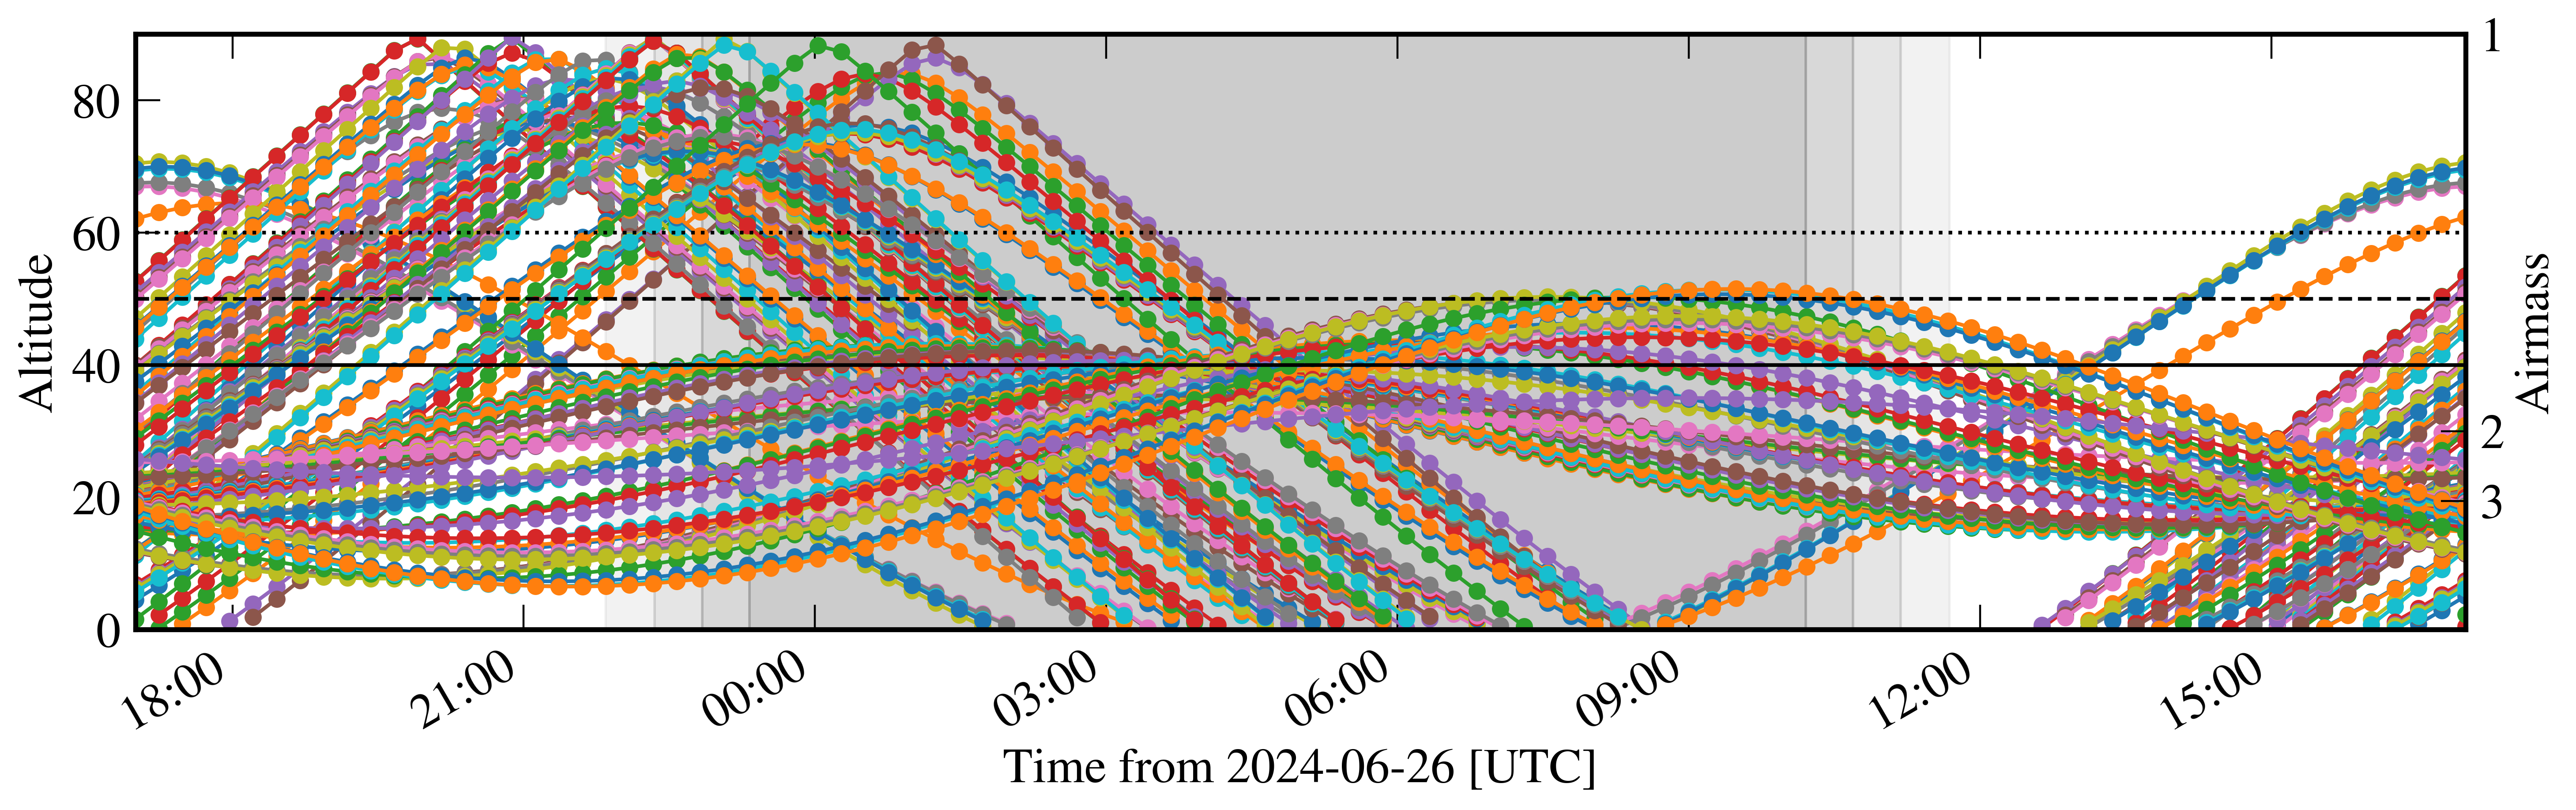

In [87]:
plt.figure(figsize = (15, 5))
plot_altitude(amtarg, observer = lco, time = time, brightness_shading = True,
             airmass_yaxis = True)

# plot_altitude(amtarg[targets['selection']=='ngc1851'], observer = lco, time = time, brightness_shading = True,
#              airmass_yaxis = True, color='k')

plt.axhline(40, c='k', ls='-')
plt.axhline(50, c='k', ls='--')
plt.axhline(60, c='k', ls=':')
plt.tight_layout()

In [88]:
for stream in ['hvs',]:
    print(np.sum(targets['selection']==stream))

126


## Observing schedule

In [89]:
# set exposure times based on magnitudes
targets['texp'] = np.zeros(len(targets))
ind_ts = (targets['phot_g_mean_mag']<7)
ind_t0 = (targets['phot_g_mean_mag']>=7) & (targets['phot_g_mean_mag']<9)
ind_t1 = (targets['phot_g_mean_mag']<17.5)
ind_t2 = (targets['phot_g_mean_mag']>=17.5) & (targets['phot_g_mean_mag']<18.5)
ind_t3 = (targets['phot_g_mean_mag']>=18.5)

targets['texp'][ind_ts] = 1
targets['texp'][ind_t0] = 20
targets['texp'][ind_t1] = 600
targets['texp'][ind_t2] = 900
targets['texp'][ind_t3] = 1200

In [90]:
import ephem
from datetime import datetime

In [91]:
def lco_observer(date):
    """Return pyephem observer at LCO"""
    
    site = coord.EarthLocation.of_site('lco')
    
    # general 
    lco = ephem.Observer()
    lco.lon = '{:.4f}'.format(site.lon.deg)
    lco.lat = '{:.4f}'.format(site.lat.deg)
    lco.elev = site.height.to(u.m).value
    lco.temp = 2.0 # deg celsius; forecast for Aug 15
    lco.pressure = 746.0 # mbar
    lco.horizon = -np.sqrt(2.0*lco.elev/astropy.constants.R_earth.to(u.m).value)
    #decam.horizon = -np.sqrt(2.0*decam.elev/6378.1e3)
    #decam_long_w = 70.806525
    
    # night specific
    lco.date = date
    
    return lco

In [92]:
def get_darktime(obsdate='2025-06-25', twilight=18):
    """Return beginning and end times of astronomical twilight for a given date, angle of Sun below the horizon"""
    
    # date ephemeris object
    date = astropy.time.Time('{0} 00:00:00'.format(obsdate), scale='utc')
    current_date = date
    date_ephem = ephem.Date(date.datetime)
    observer = lco_observer(date_ephem)
    
    # times of sunset, sunrise
    sun = ephem.Sun()
    sun.compute(observer)
    sunset = '{}'.format(observer.next_setting(sun))
    sunrise = '{}'.format(observer.next_rising(sun))
    #sunset = string.replace(sunset, '/', '-')
    #sunrise = string.replace(sunrise, '/', '-')
    sunset = sunset.replace('/', '-')
    sunrise = sunrise.replace('/', '-')
    
    # astronomical twilight
    t1 = astropy.time.Time(sunset, scale='utc')
    t1 += twilight/15*u.h
    
    t2 = astropy.time.Time(sunrise, scale='utc')
    t2 -= twilight/15*u.h
    
    return(t1, t2)

In [93]:
get_darktime(twilight=18, obsdate='2025-06-25')

(<Time object: scale='utc' format='iso' value=2025-06-25 23:16:02.000>,
 <Time object: scale='utc' format='iso' value=2025-06-25 10:15:09.000>)

In [94]:
get_darktime(twilight=15)

(<Time object: scale='utc' format='iso' value=2025-06-25 23:04:02.000>,
 <Time object: scale='utc' format='iso' value=2025-06-25 10:27:09.000>)

In [95]:
get_darktime(twilight=12)

(<Time object: scale='utc' format='iso' value=2025-06-25 22:52:02.000>,
 <Time object: scale='utc' format='iso' value=2025-06-25 10:39:09.000>)

In [96]:
get_darktime(twilight=0)

(<Time object: scale='utc' format='iso' value=2025-06-25 22:04:02.000>,
 <Time object: scale='utc' format='iso' value=2025-06-25 11:27:09.000>)

In [97]:
t1, t2 = get_darktime()
start_time = t1.utc.iso.split(' ')[1]
end_time = t2.utc.iso.split(' ')[1]

In [98]:
# date
obsdate = '2025-06-26'

# start time
date = astropy.time.Time('{0} {1}'.format(obsdate, start_time), scale='utc')
current_date = date
date_ephem = ephem.Date(date.datetime)

# end time
date_end = astropy.time.Time('{0} {1}'.format(obsdate, end_time), scale='utc')
date_end += 1*u.day

observing_time = date_end - date

In [99]:
date, date_end, observing_time.to(u.h)

(<Time object: scale='utc' format='iso' value=2025-06-26 23:16:02.000>,
 <Time object: scale='utc' format='iso' value=2025-06-27 10:15:09.000>,
 <Quantity 10.98527778 h>)

In [100]:
print(targets.colnames)

['name', 'RAstring', 'DEstring', 'phot_g_mean_mag', 'SpType', 'source_id', 'ra', 'dec', 'selection', 'pmra', 'pmdec', '_RAJ2000', '_DEJ2000', 'HIP', 'RAJ2000', 'DEJ2000', 'Vmag', 'B-V', 'Cat', 'RV', 'eRV', 'sRV', 'VC', 'N', 'e_RV', 'Tbase', 'JDm', 'Simbad', '_RA', '_DE', 'separation_arcsec', 'solution_id', 'random_index', 'ref_epoch', 'ra_error', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra_error', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec

In [101]:
def best_airmass(data, to_observe, observer):
    """Return ID of the tile with the best airmass"""
    
    zmin = 10
    zmax = 1.
    current = 0
    for it in to_observe:
        i = it-1
        current_tile = data[i]
        ephem_object = '{0},f,{1},{2},20'.format(current_tile['shortname'], 
                                                    coord.Angle(current_tile['ra']*u.deg).to_string(unit=u.hour, sep=':'), 
                                                    coord.Angle(current_tile['dec']*u.deg).to_string(unit=u.deg, sep=':'))
        tile = ephem.readdb(ephem_object)
        
        # get airmass at the present time
        tile.compute(observer)
        airmass = get_airmass(float(tile.alt))
        
        if (airmass<zmin) & (airmass>zmax):
            zmin = airmass
            current = i
    
    return current

def get_airmass(altitude):
    """Return airmass at a given altitude, following Hardie 1962"""
    
    secz = 1.0/np.sin(altitude)
    seczm1 = secz - 1.0
    airmass = secz - 0.0018167*seczm1 - 0.002875*seczm1**2 - 0.0008083*seczm1**3
    
    return airmass

In [102]:
start_time

'23:16:02.000'

In [220]:
start_time = '00:30:00.000'
end_time = '05:20:00.000'

In [259]:
# date
obsdate = '2025-06-28'

# start time
date = astropy.time.Time('{0} {1}'.format(obsdate, start_time), scale='utc')
current_date = date
date_ephem = ephem.Date(date.datetime)
print(current_date)

# end time
date_end = astropy.time.Time('{0} {1}'.format(obsdate, end_time), scale='utc')
date_end += 1*u.day

observing_time = date_end - date

# create observer
observer = lco_observer(date_ephem)

# plan dictionary
plan = {}
plan_keys = ['#', 'name', 'ra', 'dec', 'datetime', 'airmass', 'exptime', 'class']
for key in plan_keys:
    plan[key] = []
    
# time-scales
time_elapsed = 0*u.s
overheads = 5*u.min
slew_overhead = 3*u.s

Nobs = 0
base_exptime = 900
ceil_exptime = 1200
floor_exptime = 600

# star ids to observe
# Jun 26
to_observe = np.array([23, 30, 39, 41, 37, 42, 44, 50, 60, 62, 65, 69, 82, 88, 91, 94
                      ])

to_observe = np.array([23, 30, 39, 41, 42, 44, 50, 60, 62, 69, 88, 94, 103, 117
                      ])

# Jun 27
to_observe = np.array([34, 37, 65, 72, 82, 90, 112, 115, 118, 121, 126, 128, 131, 132
                      ])

# to_observe = np.array([34, 37, 65, 72, 82, 90, 112, 115, 118, 121, 122, 123, 126, 131
#                       ])


# initial tile
pra = targets[to_observe[0]]['ra']
pdec = targets[to_observe[0]]['dec']

# make the plan
while (time_elapsed<=observing_time+1*u.hr) & (Nobs==0) & (np.size(to_observe)>0):
    while (time_elapsed<=observing_time+1*u.hr) & (Nobs<50) & (np.size(to_observe)>0):
        # find the next target to observe
#         try:
#             current = best_airmass(targets, to_observe, observer)
#         except ValueError:
#             break
        current = to_observe[0]-1
        current_tile = targets[current]

        # distance from previous pointing
        delta_deg = np.sqrt((pra - current_tile['ra'])**2 + (pdec - current_tile['dec'])**2)

        # create ephem object
        ephem_object = '{0},f,{1},{2},20'.format(current_tile['shortname'], 
                                                coord.Angle(current_tile['ra']*u.deg).to_string(unit=u.hour, sep=':'),
                                                coord.Angle(current_tile['dec']*u.deg).to_string(unit=u.deg, sep=':'))
        tile = ephem.readdb(ephem_object)

        # exposure time
        exptime = current_tile['texp']

        # get airmass at the present time
        tile.compute(observer)
        airmass = get_airmass(float(tile.alt))
#         print(current_tile['#'], current_date, float(tile.alt), airmass)

#         # exposure scaling
#         if scale_exposures:
#             scale = exposure_scaling(airmass, 'z', current_tile['EBV'], seeing=1.3)
#             exptime *= scale

#         # min and max exposure limits
#         if exptime>, eil_exptime: exptime = ceil_exptime
#         if exptime<floor_exptime: exptime = floor_exptime

        # exposure time in int format
        exptime = np.int64(current_tile['texp'])
        
#         # probability
#         if current_tile['Class']=='ngc1261':
#             prob = current_tile['ptot']
#         else:
#             prob = current_tile['w1a']

        if (airmass<2) & (airmass>0):
            # add to the plan
            plan['#'].append(int(current_tile['#']))
            plan['name'].append(current_tile['shortname'])
            plan['ra'].append(current_tile['ra'])
            plan['dec'].append(current_tile['dec'])
            plan['datetime'].append(current_date.iso)
            plan['airmass'].append(airmass)
            plan['exptime'].append(exptime)
            plan['class'].append(current_tile['Class'])
#             plan['prob'].append(prob)

            # move forward in time
#             time_elapsed += 1.333*exptime*u.s + overheads + slew_overhead*max(delta_deg - 2.0, 0.0)
            time_elapsed += 1.*exptime*u.s + overheads + slew_overhead*max(delta_deg - 2.0, 0.0)
            current_date = date + time_elapsed
            observer.date = ephem.Date(current_date.datetime)

#             print(current_tile['#'], current_tile['shortname'], airmass, float(tile.alt), 
#                   get_airmass(float(tile.alt)), time_elapsed.to(u.h), exptime)
            print(current_tile['#'], '{:.2f}'.format(time_elapsed.to(u.h)), exptime, current_date, 
                  '{:.2f}'.format(airmass))

            # update previous position
            pra = current_tile['ra']
            pdec = current_tile['dec']
            ind = np.arange(np.size(to_observe), dtype=int)[to_observe==current+1]
            to_observe = np.delete(to_observe, ind)
#             print(to_observe, time_elapsed.to(u.hr), (observing_time+1*u.hr).to(u.hr))

        Nobs +=1

    # if no tiles work now, check 15min later
    time_elapsed += base_exptime*u.s
    current_date = date + time_elapsed
    observer.date = ephem.Date(current_date.datetime)

t = Table(plan)
t = t[plan_keys]

2025-06-28 00:30:00.000
034 0.43 h 1200 2025-06-28 00:55:49.341 1.41
037 0.78 h 900 2025-06-28 01:16:52.616 1.33
065 1.13 h 900 2025-06-28 01:37:38.094 1.18
072 1.56 h 1200 2025-06-28 02:03:23.268 1.12
082 1.92 h 900 2025-06-28 02:25:00.745 1.49
090 2.34 h 1200 2025-06-28 02:50:10.880 1.48
112 2.81 h 1200 2025-06-28 03:18:42.164 1.62
115 3.24 h 1200 2025-06-28 03:44:25.221 1.71
118 3.66 h 1200 2025-06-28 04:09:47.192 1.60
121 4.08 h 1200 2025-06-28 04:35:01.841 1.65
126 4.43 h 900 2025-06-28 04:55:39.111 1.72
128 4.84 h 1200 2025-06-28 05:20:39.111 1.67
131 5.18 h 900 2025-06-28 05:40:53.169 1.62
132 5.60 h 1200 2025-06-28 06:05:54.320 1.57


In [232]:
order = [34, 37, 65, 82, 91, 72, 90, 112, 115, 118, 121, 122, 123]
ind_order = np.array([int(idx) in order for idx in targets['#']])

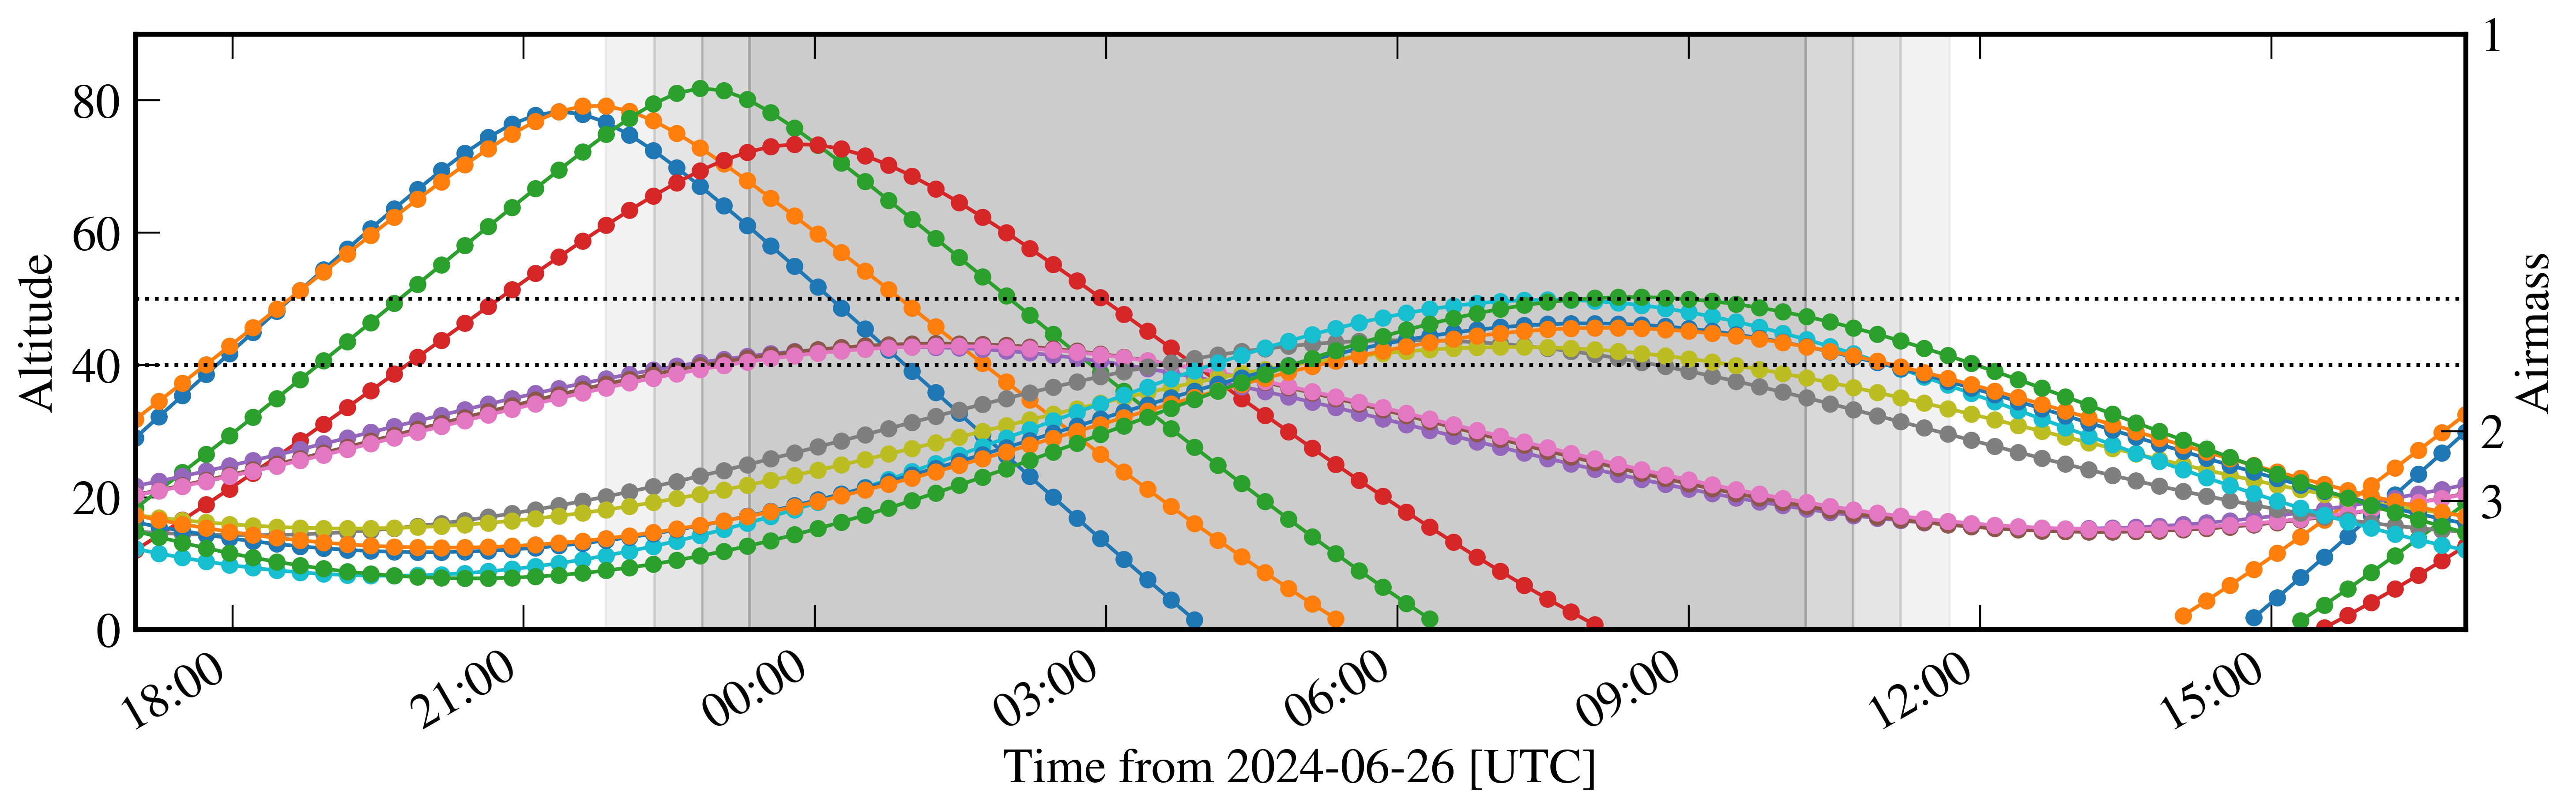

In [233]:
plt.figure(figsize = (15, 5))
plot_altitude(np.array(amtarg)[ind_order].tolist(), observer = lco, time = time, brightness_shading = True,
             airmass_yaxis = True)

plt.axhline(40, c='k', ls=':')
plt.axhline(50, c='k', ls=':')
plt.tight_layout()

In [198]:
np.sum(ind_order)

np.int64(14)

In [199]:
# total available: 4.3hr
(np.sum(targets['texp'][ind_order]) + np.sum(ind_order) * 4 * 60)/3600

np.float64(4.433333333333334)

## Observing progress

### Priorities

In [115]:
targets

<Table length=132>
  name        RAstring        DEstring   ...    G    Class   texp 
                                         ...                      
 str16         str17           str13     ... float64  str4 float64
-------- ----------------- ------------- ... ------- ----- -------
HIP69104       14:08:44.35   -42:35:55.2 ...     8.7  tell   600.0
HIP70993       14:31:13.08   -34:40:52.0 ...     7.8  tell   600.0
HIP70097       14:20:37.35   -34:40:40.4 ...     7.7  tell   600.0
HIP69157      14:09:24.969 -34:52:58.467 ...     7.8   rvs   600.0
HIP72600 14:50:37.92973333 -32:27:59.506 ...     7.5   rvs   600.0
HIP72353      14:47:43.388 -27:41:56.628 ...     7.6   rvs   600.0
      --                --            -- ...    19.1   hvs  1200.0
      --                --            -- ...    16.3   hvs   600.0
      --                --            -- ...    17.4   hvs   600.0
     ...               ...           ... ...     ...   ...     ...
      --                --            -- ...    17.3   hvs   600.0
      --                --            -- ...    18.1   hvs   900.0
      --                --            -- ...    18.3   hvs   900.0
      --                --            -- ...    19.6   hvs  1200.0
      --                --            -- ...    18.8   hvs  1200.0
      --                --            -- ...    18.3   hvs   900.0
      --                --            -- ...    16.6   hvs   600.0
      --                --            -- ...    18.4   hvs   900.0
      --                --            -- ...    19.2   hvs  1200.0

In [116]:
ct = coord.SkyCoord(ra=targets['ra'], dec=targets['dec'], pm_ra_cosdec=targets['pmra'], pm_dec=targets['pmdec'])
ctg = ct.transform_to(coord.Galactic())

theta_b = (np.arctan2(ctg.pm_b.value, ctg.pm_l_cosb.value)*u.radian).to(u.deg)

In [225]:
ind_pm = np.abs(theta_b)<150*u.deg
ind_mag = (targets['phot_g_mean_mag']>17.5) & (targets['phot_g_mean_mag']<19.5)
print(np.sum(ind_pm), np.sum(ind_mag & ind_pm))

60 43


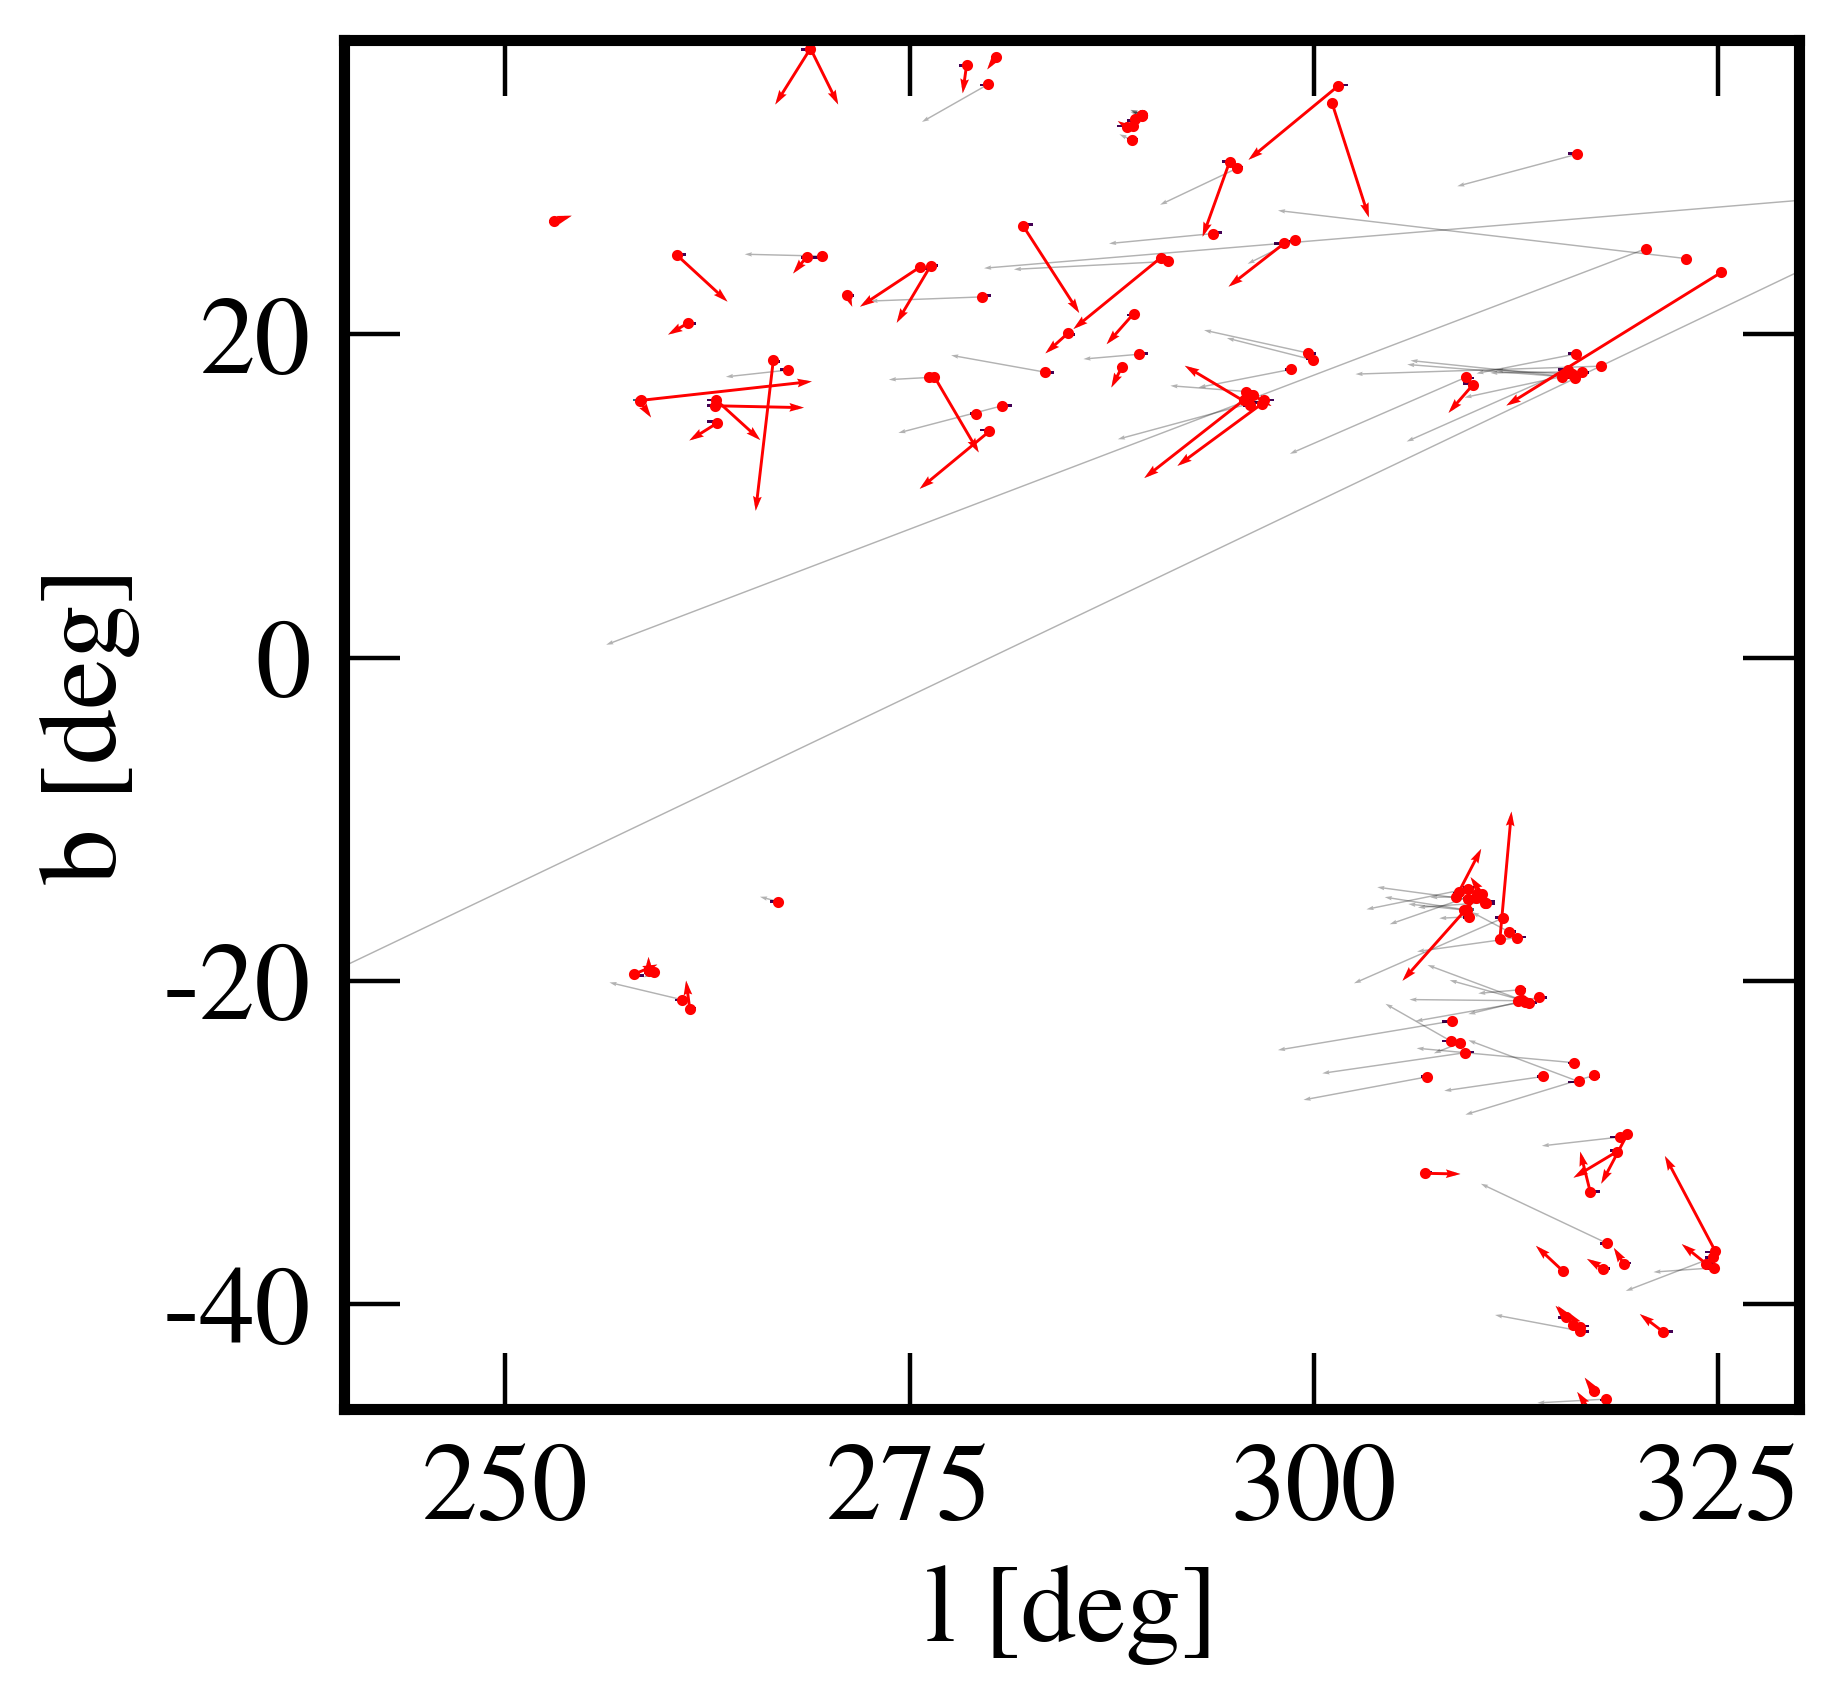

In [234]:
plt.figure(figsize=(5,5))

plt.hist2d(targets['glon'], targets['glat'], bins=(500,500), norm=mpl.colors.LogNorm());
plt.plot(ctg.l, ctg.b, 'ro', ms=1)
plt.quiver(np.array(ctg.l), np.array(ctg.b), np.array(ctg.pm_l_cosb), np.array(ctg.pm_b), color='k', scale=100, width=1e-3, alpha=0.3)
plt.quiver(np.array(ctg.l[ind_pm]), np.array(ctg.b[ind_pm]), np.array(ctg.pm_l_cosb[ind_pm]), np.array(ctg.pm_b[ind_pm]), 
           color='r', scale=100, width=2e-3)

plt.gca().set_aspect('equal')
# plt.gca().invert_xaxis()
plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
plt.xlim(240,330)

plt.tight_layout()

In [227]:
targets['raw'] = Angle(targets['ra']).wrap_at('180d') # wrapped RA

In [266]:
# indicate which numbers have already been observed

obs = [23, 39, 41, 42, 44, 50, 60, 62, 69, 88, 94, 103,
      34, 37, 65, 72, 82, 90, 112, 115, 118, 121]

unobs = np.array([int(idx) not in obs for idx in targets['#']])
obs = ~unobs
print(np.sum(obs))

22


25
11


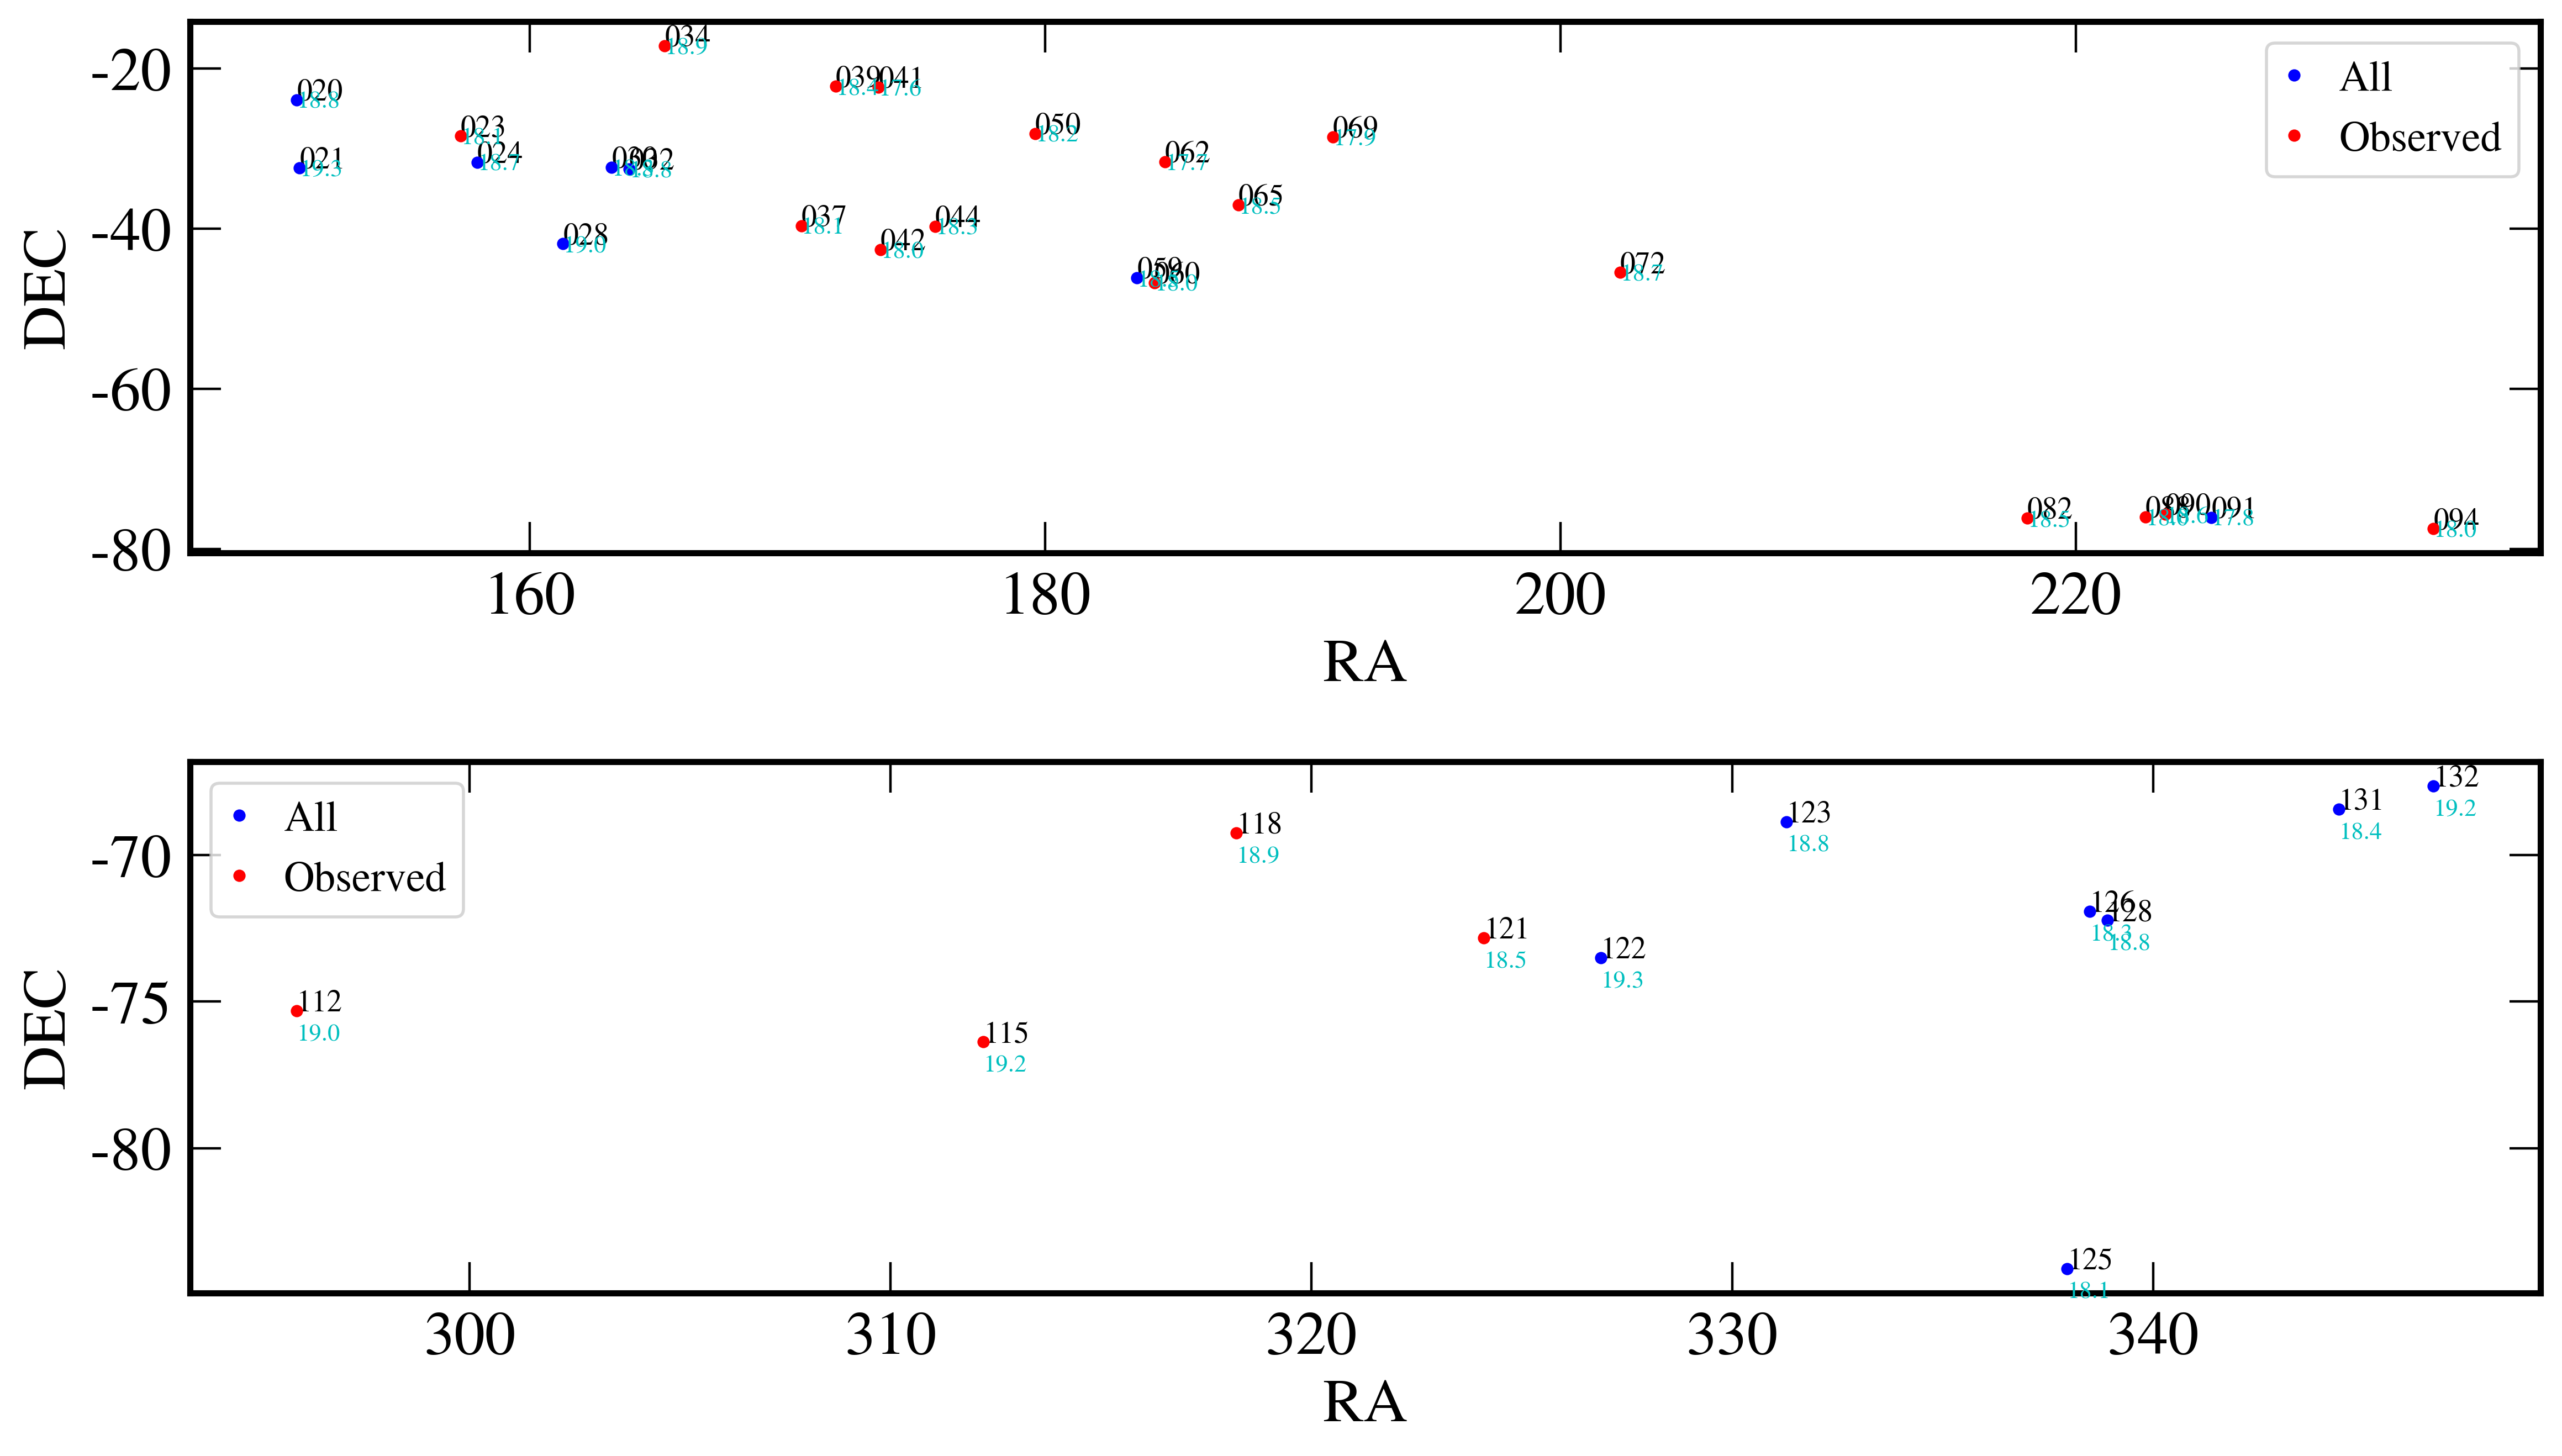

In [267]:
fig, ax = plt.subplots(2, 1, figsize=(12,7))

ind_ras = [(ct.ra<250*u.deg) & (ct.ra>150*u.deg), (ct.ra>250*u.deg) & (ct.ra>150*u.deg)]

for i in range(2):
    ind_target = (targets['selection']=='hvs') & ind_pm & ind_mag & ind_ras[i]
    print(np.sum(ind_target))
    plt.sca(ax[i])
    plt.plot(targets['ra'][ind_target & unobs], targets['dec'][ind_target & unobs], 'bo', ms=3, label='All')
    plt.plot(targets['ra'][ind_target & obs], targets['dec'][ind_target & obs], 'ro', ms=3, label='Observed')
    
    for i in range(np.sum(ind_target)):
        plt.annotate(targets['#'][ind_target][i], 
                     (targets['ra'][ind_target][i], targets['dec'][ind_target][i]), 
                     fontsize=10, zorder=0)
    
        plt.text(ct.ra.value[ind_target][i], ct.dec.value[ind_target][i]-1,
                 '{:.1f}'.format(targets['phot_g_mean_mag'][ind_target][i]),fontsize=8, color='c')
    
    # plt.gca().set_aspect('equal', adjustable='datalim')
    plt.legend(loc=0, fontsize='x-small', handlelength=0.5)
    
    plt.xlabel('RA')
    plt.ylabel('DEC')
plt.tight_layout()
# plt.savefig('../plots/targets_progress_20240612.png')

25
11


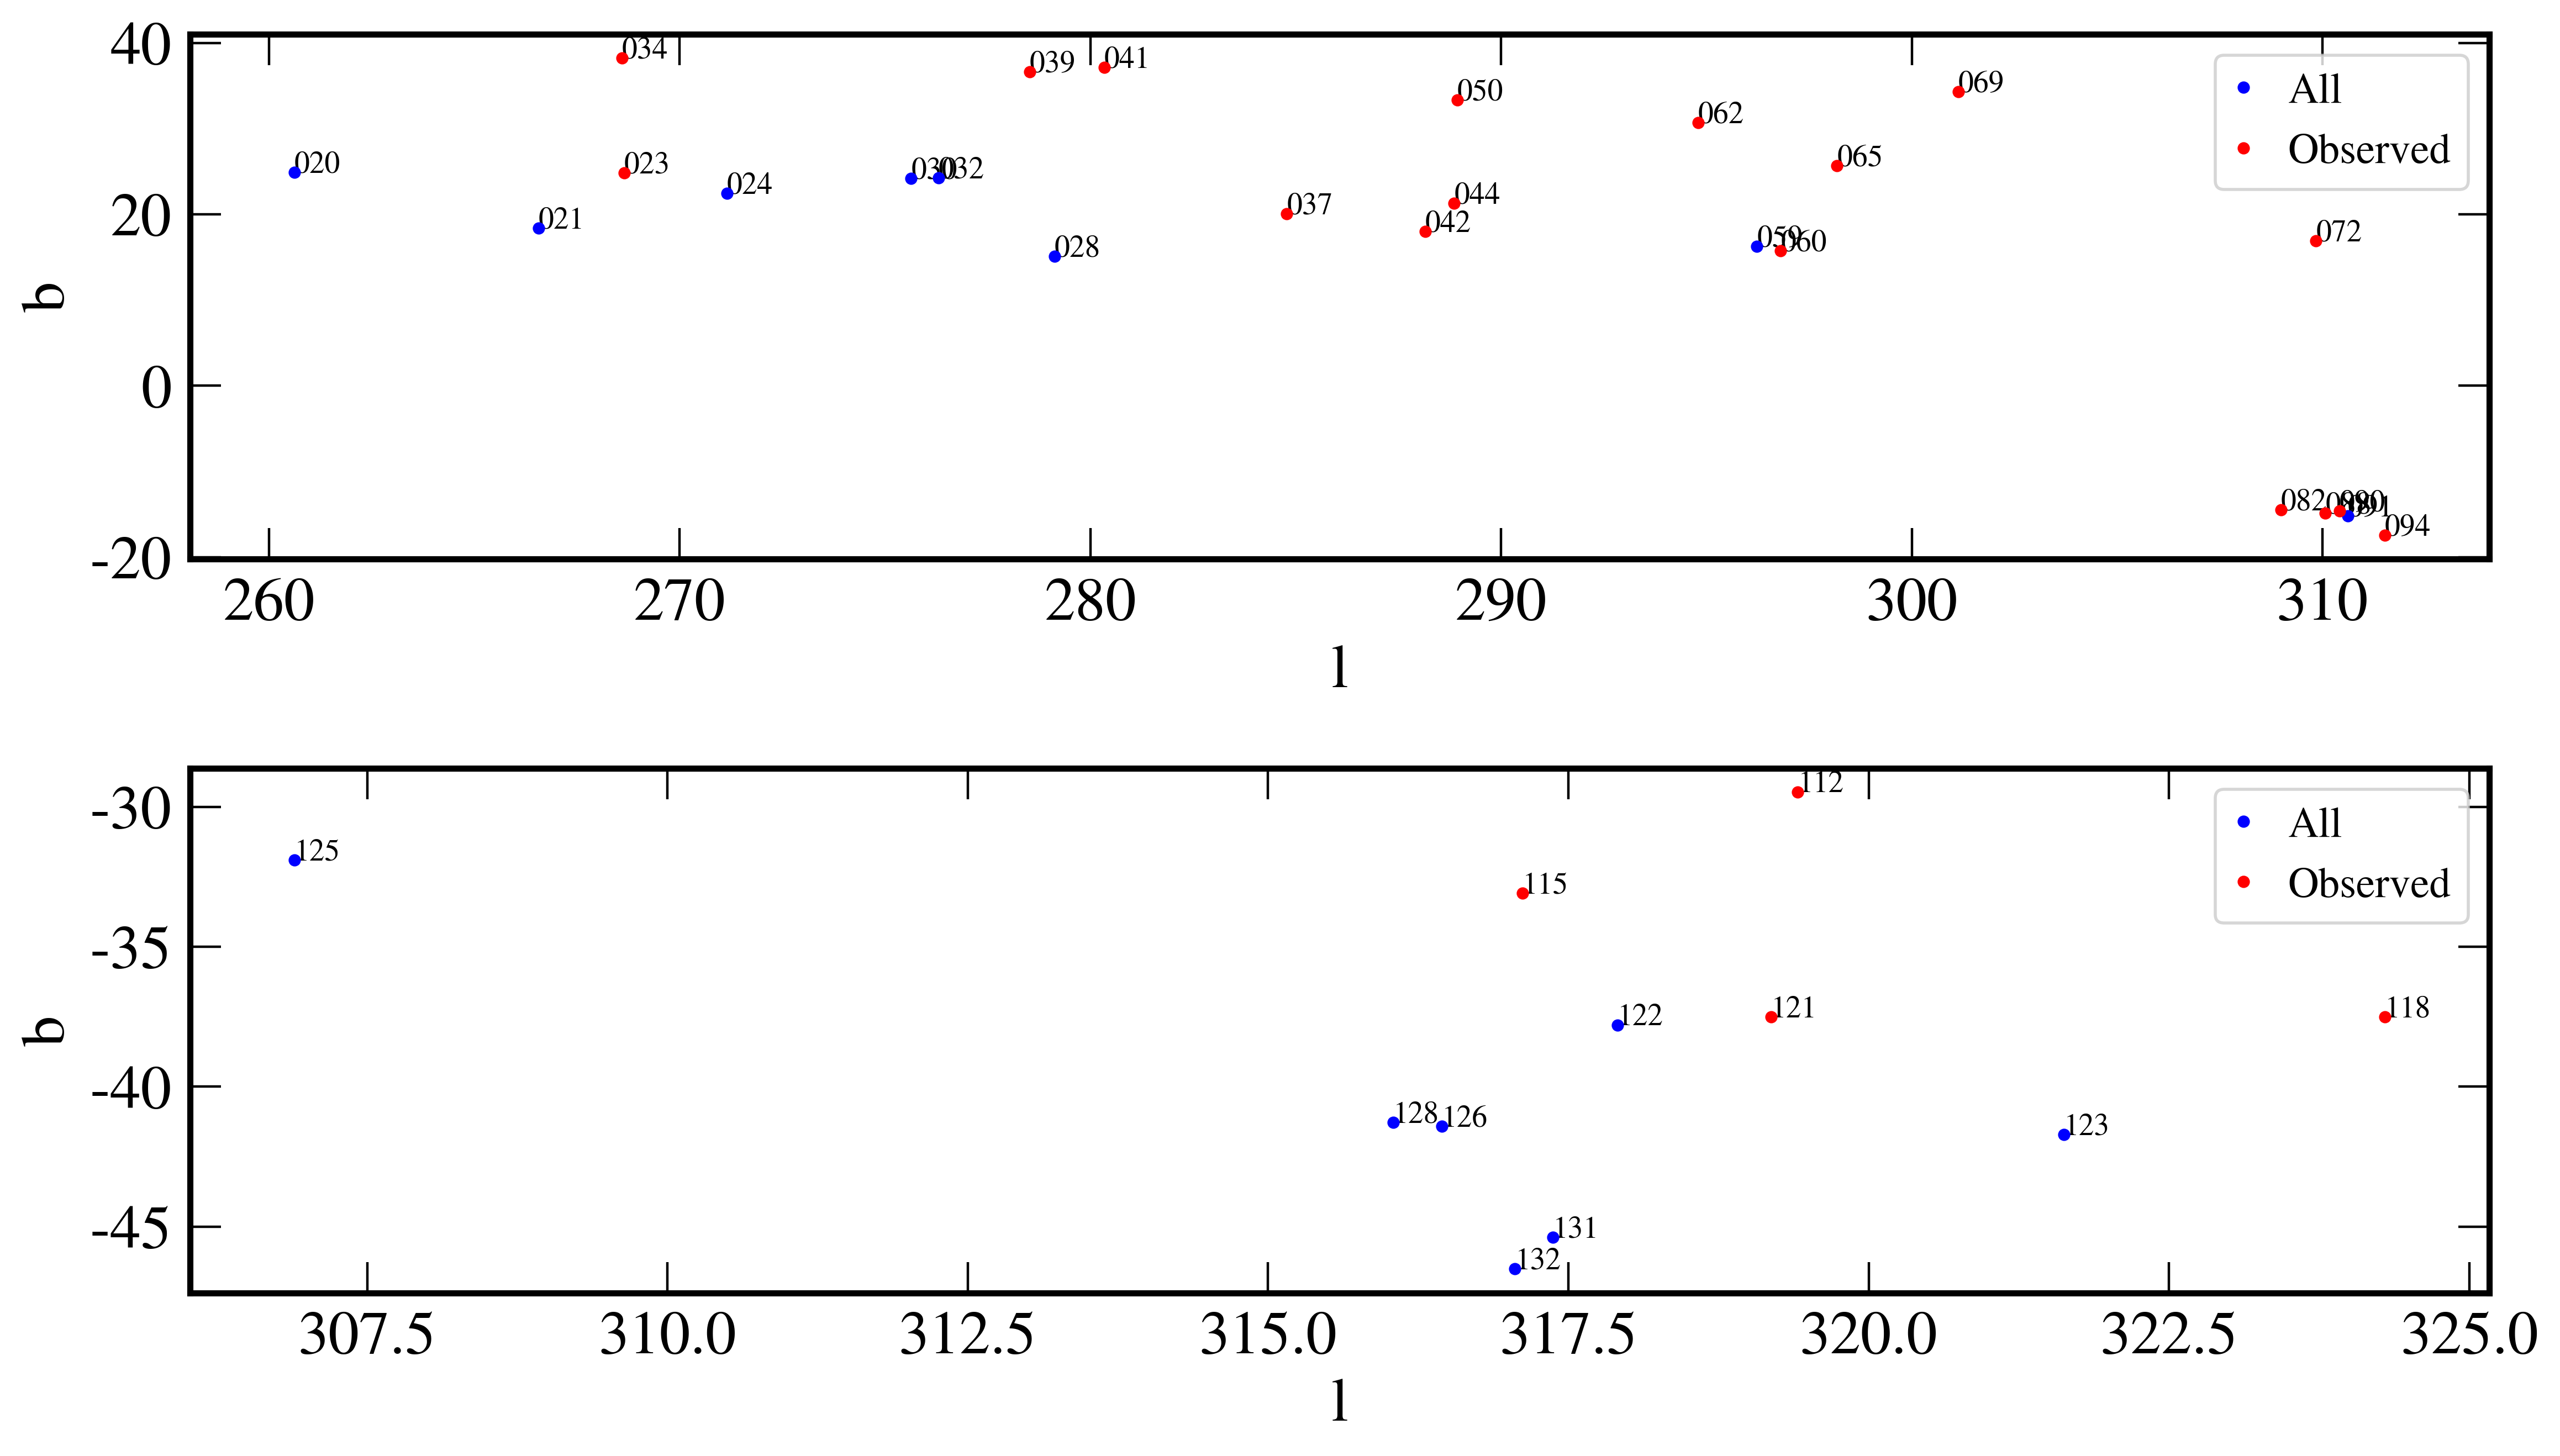

In [268]:
fig, ax = plt.subplots(2, 1, figsize=(12,7))

ind_ras = [(ct.ra<250*u.deg) & (ct.ra>150*u.deg), (ct.ra>250*u.deg) & (ct.ra>150*u.deg)]

for i in range(2):
    ind_target = (targets['selection']=='hvs') & ind_pm & ind_mag & ind_ras[i]
    print(np.sum(ind_target))
    plt.sca(ax[i])
    plt.plot(ctg.l[ind_target & unobs], ctg.b[ind_target & unobs], 'bo', ms=3, label='All')
    plt.plot(ctg.l[ind_target & obs], ctg.b[ind_target & obs], 'ro', ms=3, label='Observed')
    
    for i in range(np.sum(ind_target)):
        plt.annotate(targets['#'][ind_target][i], 
                     (ctg.l.deg[ind_target][i], ctg.b.deg[ind_target][i]), 
                     fontsize=10, zorder=0)
    
    #     plt.text(ct.ra.value[ind_target][i], ct.dec.value[ind_target][i]-1,
    #              '{:.1f}'.format(targets['phot_g_mean_mag'][ind_target][i]),fontsize=8, color='c')
    
    # plt.gca().set_aspect('equal', adjustable='datalim')
    plt.legend(loc=0, fontsize='x-small', handlelength=0.5)
    
    plt.xlabel('l')
    plt.ylabel('b')
plt.tight_layout()